In [1]:
# Main imports
import numpy as np
import pandas as pd

# Import matplotlib and such
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.ion()

from helper_functions import \
    thermodynamic_model, \
    plot_manifold_model, \
    plot_manifold_measurements, \
    get_measurement_subset_df
    

In [2]:
# Set global styles
textwidth=5.5
halfcolwidth=3
fontsize=8
titlesize=10
panel_label_size=12
legend_fontsize=7
markersize=5
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = False

# Get default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Used to create color gradient across data points of different P values
color_strong = np.array([.11, .69, .93])
color_weak = np.array([1.00, .94, .21])

# Conversion parameter
kbt_to_kcal = 1/1.62

# The correction factor used
f_used = 0.855

In [3]:
# Load clonal measurements 
data_df = pd.read_excel('../data/results.xlsx', sheet_name='measurements_summary').set_index('name')
data_df.head()

,location,log_t+,dlog_t+,log_t-,dlog_t-,num_t+,num_t-,outlier,spacing,sequence
name,,,,,,,,,,
61c-oc0,b5E4,-1.691993,0.146085,1.357366,0.088154,6,6,0.0,0.5,CGCAATGAATCACTCCATTGAGTGTTTTGAGGGTCCCCAGGCTTTA...
61c-ocl,b5A8,-4.955585,0.477209,-2.652523,0.185727,12,6,0.0,4.5,CGCAATGAATCACTCCATTGAGTGTTTTGAGGGTCCCCAGGCTTTA...
61c-ocl.35L01,b5B2,-5.426847,1.395136,-3.139291,0.053276,15,9,0.0,4.5,CGCAATGAATCACTCCATTGAGTGTTTTGAGGGTCCCCAGGGTTTA...
61c-ocl.35L02,b5B3,-5.057494,1.232833,-2.840256,0.373761,15,9,0.0,4.5,CGCAATGAATCACTCCATTGAGTGTTTTGAGGGTCCCCAGGCTTTA...
61c-ocl.35L04,b5B5,-4.600446,0.550925,-4.516905,0.056885,14,6,0.0,4.5,CGCAATGAATCACTCCATTGAGTGTTTTGAGGGTCCCCACCCTTAA...


Num crp_null promoters: 39
Best estimate [95% CI]: f = 0.852 [-0.053, +0.056]


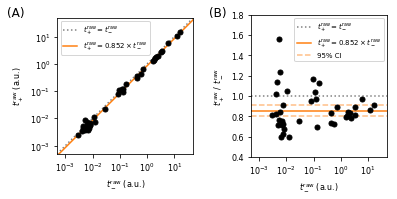

In [4]:
samples_labels_colors = [
    ('r17\.35L..\.10cons', 'no CRP site', 'k'),
    ('c-r17', 'no CRP site','k'),
    ('61c-r18', 'no CRP site', 'k'),
]

# Extract measurements 
x = []
y = []
for (sample, label, color) in samples_labels_colors:
    df = get_measurement_subset_df(data_df, regex=sample)
    y.extend(list(df['log_t+'].values))
    x.extend(list(df['log_t-'].values))
x = np.array(x) - np.log(f_used)
y = np.array(y)

print('Num crp_null promoters: %d'%len(x))

# Compute best-fit ratio f
log_fs = np.array(y) - np.array(x)

# Get best estimate for ratio f
log_f = np.mean(log_fs)
f = np.exp(log_f)

# Get 95% CI for ratio
dlog_f = np.std(log_fs)/np.sqrt(len(log_fs)-1)
f_minus = np.exp(log_f - 1.96*dlog_f)
f_plus = np.exp(log_f + 1.96*dlog_f)
print('Best estimate [95%% CI]: f = %.3f [-%.3f, +%.3f]'%(f,f-f_minus,f_plus-f))

# Specify figure size and arrangement
fig, axs = plt.subplots(1,2,figsize=[textwidth,2.75])
lim=np.array([5E-4,5E1])

### Panel A: t_+ vs t_-
ax = axs[0]

# Plot diagonal lines

ax.loglog(lim,lim,':', label='$t_+^\\mathrm{raw} = t_-^\\mathrm{raw}$', color='k', alpha=.5)
ax.loglog(lim,f*lim,'-', label='$t_+^\\mathrm{raw} = %0.3f\\times t_-^\\mathrm{raw}$'%f, color=colors[1])

# Plot data points
ax.loglog(np.exp(x),np.exp(y),'ok', markersize=5)

# Style plot
ticks=[1E-3,1E-2,1E-1,1E0,1E1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.get_xaxis().set_tick_params(which='minor', size=0, labelsize=fontsize) 
ax.get_yaxis().set_tick_params(which='minor', size=0, labelsize=fontsize)
ax.set_xlabel('$t_-^\\mathrm{raw}$ (a.u.)')
ax.set_xlim(lim)
ax.set_ylabel('$t_+^\\mathrm{raw}$ (a.u.)')
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(fontsize=7)

### Panel B: t_+/t_- vs t_-
ax = axs[1]

# Plot diagonal lines
ax.axhline(1,linestyle=':',label='$t_+^\\mathrm{raw} = t_-^\\mathrm{raw}$', color='k', alpha=.5)
ax.axhline(f,linestyle='-',label='$t_+^\\mathrm{raw} = %0.3f\\times t_-^\\mathrm{raw}$'%f, color=colors[1])

ax.axhline(f_minus,linestyle='--', color=colors[1], alpha=.5, label='95% CI')
ax.axhline(f_plus,linestyle='--', color=colors[1], alpha=.5)


# Plot data points
ax.semilogx(np.exp(x),np.exp(y-x),'ok', markersize=markersize)

# Style plot
ylim = [.5,1.6]
ax.set_yticks([0.4,0.6,.8,1,1.2,1.4,1.6,1.8])
ax.set_xlabel('$t_-^\\mathrm{raw}$ (a.u.)')
ax.set_ylabel('$t_+^\\mathrm{raw} \ /\  t_-^\\mathrm{raw}$')
ax.legend(fontsize=7)

# Fix up and show figure
ax.set_xticks(ticks)
ax.get_xaxis().set_tick_params(which='minor', size=0, labelsize=fontsize) 
ax.set_xlim(lim)
ax.set_ylim([.4,1.8])

plt.tight_layout(w_pad=2)

### Add panel labels
plt.figtext(.01,.98,'(A)', fontsize=panel_label_size, horizontalalignment='left', verticalalignment='top')
plt.figtext(.52,.98,'(B)', fontsize=panel_label_size, horizontalalignment='left', verticalalignment='top')


plt.savefig('../figures/plt_crp_null.pdf', transparent=True)
plt.show()